# Classification of Malaria cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

Reconstructing cell cycle and disease progression using deep learning. https://doi.org/10.1038/s41467-017-00623-3

We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

we used this example to show that scifAI can be used for a variety of datasets and images

In [ ]:
!pip -q install /pstore/home/shetabs1/code/MarrLab/scifAI/

here we import a series of needed modules. 

In [ ]:
import scifAI
import matplotlib.pyplot as plt
import scifAI.ml.features as features
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.ml.segmentation import segment_all_channels
import numpy as np
import pandas as pd
import os
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [ ]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred))
    print(classification_report_imbalanced(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

considering that the images are not in the expected format of the scifAI, we need to create our own metadata generator based on the images and their directories

In [ ]:
%%time

data_path = "/pstore/data/DS4/ssl_vs_al/data/malaria/"

metadata_columns = ["file", "set", "label"]
metadata = pd.DataFrame(columns=metadata_columns)

for cl in ["Parasitized", "Uninfected"]:
    metadata_dummy = pd.DataFrame(columns=metadata_columns)
    metadata_dummy["file"] = glob.glob(os.path.join(data_path, cl, "*.png"))
    metadata_dummy["set"] = "train"
    metadata_dummy["label"] = cl
    metadata = metadata.append(metadata_dummy, ignore_index = True)
    metadata_dummy = None
     


<AxesSubplot:>

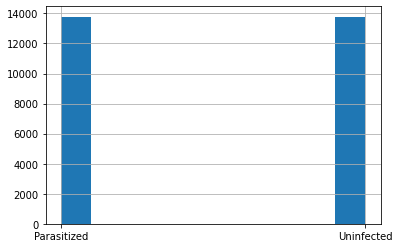

In [5]:
metadata.label.hist()

to reduce calculation time, we subsample the data

In [6]:
metadata = metadata.sample(10000).reset_index(drop = True)

now lets create the feature_union

In [7]:

feature_union = FeatureUnion([
                                ("MaskBasedFeatures", features.MaskBasedFeatures()), 
                                ("GLCMFeatures", features.GLCMFeatures()),  
                                ("GradientRMS", features.GradientRMS()),  
                                ("BackgroundMean", features.BackgroundMean()), 
                                ("PercentileFeatures", features.PercentileFeatures()), 
                                ("CellShape", features.CellShape()),  
                                ("Collocalization", features.Collocalization()),    
                                ("IntersectionProperties", features.IntersectionProperties()),
                                ("CenterOfCellsDistances", features.CenterOfCellsDistances()),
]
)

In [8]:
from scifAI.ml.segmentation import SegmentationGenerator

pipeline = Pipeline([
                     ("features", feature_union)], verbose=3)


here also because the task is a bit different, we write our own feature extractor

In [9]:
import pandas as pd
import h5py
from joblib import Parallel, delayed
from tqdm import tqdm
from scifAI.ml.segmentation import segment_all_channels
from scifAI.utils import list_of_dict_to_dict
from skimage.io import imread

class FeatureExtractor(object):
    def __init__(self, feature_unions):
        self.feature_unions = feature_unions

    def extract_(self, f):
        try:    
            image = imread(f)
            mask = (image > 0.).astype(int)
            features = self.feature_unions.transform([image,mask]).copy()
            features = list_of_dict_to_dict(features)
        except:
            print("corrupted file", f)
            features = []
        return features

    def extract_features(self, metadata, n_jobs = -1):
        file_list = metadata["file"].tolist()
        results = Parallel(n_jobs=n_jobs)(delayed(self.extract_)(f) \
            for f in tqdm(file_list, position=0, leave=True) )
        return results

    def get_image_mask(self, metadata, i = 0):
        image = imread(metadata.loc[i,"file"])
        mask = (image > 0.).astype(int)
        return image, mask
    
feature_extractor = FeatureExtractor(pipeline)

before running the feature extraction, lets look at a random sample (the 0th entry in the metadata dataframe)

In [10]:
image, mask = feature_extractor.get_image_mask(metadata, 0)

In [11]:
image.shape

(148, 112, 3)

[]

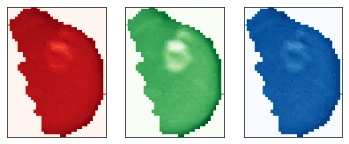

In [12]:
sns.set_style("white")
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 3, 
                       sharex = True, 
                       sharey = True)

ax[0].imshow(image[:,:,0], cmap = "Reds")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(image[:,:,1], cmap = "Greens")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(image[:,:,2], cmap = "Blues")
ax[2].set_xticks([])
ax[2].set_yticks([])


In [13]:

list_of_features = feature_extractor.extract_features(metadata)

100%|██████████| 10000/10000 [02:05<00:00, 79.90it/s]


lets create a dataframe with the metadata

In [14]:
df_features = pd.DataFrame(list_of_features)

In [15]:
df_features.head()

,mask_based_area_Ch1,mask_based_bbox_area_Ch1,mask_based_convex_area_Ch1,mask_based_eccentricity_Ch1,mask_based_equivalent_diameter_Ch1,mask_based_euler_number_Ch1,mask_based_extent_Ch1,mask_based_feret_diameter_max_Ch1,mask_based_filled_area_Ch1,mask_based_major_axis_length_Ch1,...,max_intensity_ratio_Ch2_R2_R3,sum_intensity_ratio_Ch3_R2_R3,mean_intensity_ratio_Ch3_R2_R3,max_intensity_ratio_Ch3_R2_R3,cell_distance_Ch1_Ch2,weighted_cell_distance_Ch1_Ch2,cell_distance_Ch1_Ch3,weighted_cell_distance_Ch1_Ch3,cell_distance_Ch2_Ch3,weighted_cell_distance_Ch2_Ch3
0,10498,16576,11452,0.794012,115.613445,1,0.633325,153.574086,10498,151.271685,...,2.548695,1.0,1.0,1.873857,0.0,0.584849,0.0,0.199785,0.0,0.385149
1,18118,29452,21217,0.701441,151.883357,1,0.615170,207.562039,18118,183.792548,...,1.896361,1.0,1.0,1.772543,0.0,0.248694,0.0,0.038342,0.0,0.273442
2,12598,18070,13240,0.557568,126.650195,1,0.697178,141.410749,12598,140.409486,...,1.694753,1.0,1.0,1.592228,0.0,0.253493,0.0,0.094484,0.0,0.286123
3,14842,21016,15571,0.367834,137.467892,1,0.706224,150.814456,14842,143.032969,...,1.588470,1.0,1.0,1.520238,0.0,0.054781,0.0,0.150625,0.0,0.095846
4,12001,16093,12790,0.618424,123.612895,1,0.745728,145.715476,12001,140.817985,...,1.785775,1.0,1.0,1.551371,0.0,0.673717,0.0,0.210122,0.0,0.466642


after creating the features, we impute empty values with 0. and delete features with no variance. After that, we name the features correctly based on their real name

In [16]:
df_features = df_features.fillna(0.)
df_features = df_features.loc[:, df_features.std() > 0.]

In [17]:
column_dict_rename = dict()

channel_names = {   
         "Ch1": "R",
         "Ch2": "G",
         "Ch2": "B",}

for col in df_features.columns:
    new_col = col
    for ch in channel_names:
        new_col = new_col.replace(ch,channel_names[ch] )
    column_dict_rename[col] = new_col
    
df_features = df_features.rename(columns=column_dict_rename).copy()

let's create a train, validation and test set. We simply use the indexes, as it is easier to use it with sklearn pipelines

In [19]:
from scifAI.dl.utils import train_validation_test_split


train_index, validation_index, test_index = train_validation_test_split(metadata.index, 
                                                                        metadata.loc[:,"label"],
                                                                        validation_size=0.20, 
                                                                        test_size=0.30)




lets train an XGBoost model on the data. we also use a feature selection before the classifiation to reduce the dimensionality

In [40]:
from sklearn import manifold, datasets
from sklearn import decomposition
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,RidgeCV,PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = 50 ,verbose=True)),
                 ('xgb', XGBClassifier(n_jobs = -1, n_estimators = 1000, eval_metric = "logloss") )
], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist(), :],  
       metadata.loc[train_index.tolist() + validation_index.tolist(), "label"] )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
Step 1: Find highly correlated features
Step 2: wrapper methods
Calculating mutual information
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic regression
Calculating xgb
number of similar features among all the methods: 4
From 227 initial features Selected (multicolinear): 126
Step 3: clustering over correlation of features
From 227 initial features Selected (uncorrelated): 50
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  20.9s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   7.6s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection',
                 AutoFeatureSelection(top_k=50, verbose=True)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,

              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.97      1505
  Uninfected       0.96      0.97      0.97      1495

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

                   pre       rec       spe        f1       geo       iba       sup

Parasitized       0.97      0.96      0.97      0.97      0.97      0.93      1505
 Uninfected       0.96      0.97      0.96      0.97      0.97      0.93      1495

avg / total       0.97      0.97      0.97      0.97      0.97      0.93      3000

------------------------------------------------------------
matthews correlation coeff: 0.93
Cohen Kappa score: 0.93
Cohen Kappa score: 0.93
Accuracy: 0.97 & balanced Accuracy: 0.97
macro F1 score: 0.97 & micro F1 score: 0.97
macro Precision score: 0.97 & micro Precision score: 0.97
macro Recall score: 0.97 & micro Recall score: 0.97
-

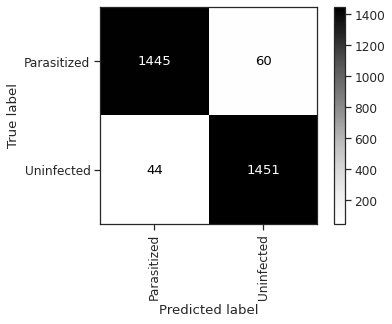

In [41]:
sns.set_style("white")
sns.set(font_scale = 1.1)

sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, :],
                               metadata.loc[test_index, "label"])

the classifier reached macro f1 of 0.72 which is comparable with the main publication. We can also look at the 50 preselected feautres using scifAI

In [42]:
selected_features = xgb.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]
selected_feature_names

Index(['mask_based_extent_R', 'mask_based_feret_diameter_max_R',
       'mask_based_max_intensity_R', 'mask_based_min_intensity_R',
       'mask_based_moments_hu-3_R', 'mask_based_moments_hu-4_R',
       'mask_based_moments_hu-6_R', 'mask_based_solidity_R',
       'mask_based_weighted_moments_hu-1_R', 'mask_based_euler_number_B',
       'mask_based_max_intensity_B', 'mask_based_mean_intensity_B',
       'mask_based_min_intensity_B', 'mask_based_weighted_moments_hu-3_B',
       'mask_based_max_intensity_Ch3', 'mask_based_mean_intensity_Ch3',
       'mask_based_min_intensity_Ch3', 'dissimilarity_R', 'contrast_B',
       'homogeneity_B', 'correlation_Ch3', 'gradient_RMS_B',
       'gradient_RMS_Ch3', 'percentile_30_R', 'percentile_40_R',
       'percentile_60_R', 'percentile_20_B', 'percentile_30_B',
       'percentile_90_B', 'sum_intensity_R', 'std_intensity_R',
       'kurtosis_intensity_R', 'skew_intensity_R', 'sum_intensity_B',
       'std_intensity_B', 'shannon_entropy_B', 'std_inten

Finally, the most important features based on the Gini-index and Permutation importance are:

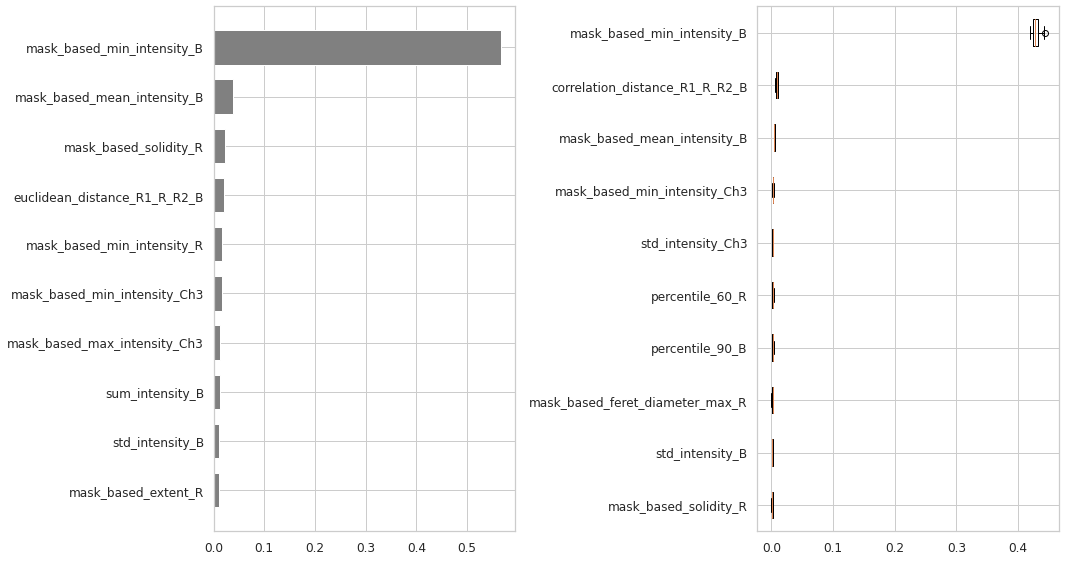

In [43]:
sns.set_style( "whitegrid" )

from sklearn.inspection import permutation_importance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(xgb.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         xgb.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(xgb, 
                                df_features.loc[test_index, :],
                                metadata.loc[test_index, "label"], 
                                n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()